# Marsh & McLennan Eastern Airlines Analysis - More perspectives


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data 

Eastern fleet data

In [2]:
## Eastern Fleet
jets = 206
eq_hrs = 10060
insured = 941600000

# Jet type proportions in full fleet
fleet = {'DC861': 17/206, 'DC863': 2/206, 'DC914':15/206, 'DC921': 14/206, 'DC93':62/206, 'DC931':5/206, '720':15/206, '727':50/206, '225':1/206, 'QC':25/206}

In [3]:
fleet

{'225': 0.0048543689320388345,
 '720': 0.07281553398058252,
 '727': 0.24271844660194175,
 'DC861': 0.0825242718446602,
 'DC863': 0.009708737864077669,
 'DC914': 0.07281553398058252,
 'DC921': 0.06796116504854369,
 'DC93': 0.30097087378640774,
 'DC931': 0.024271844660194174,
 'QC': 0.12135922330097088}

Crash Probability

In [4]:
## Probability of crash historic
hrs = 15660000
crashes = 10
ratio = crashes / hrs

# Eastern
crash_prob = (eq_hrs * jets * ratio) / jets
crash_prob

0.006424010217113665

**Probability for Modeling**

In [5]:
p = crash_prob

Jet proportions and $ value

In [6]:
## Dataframe with jet value and jet type
jetdf = pd.DataFrame.from_dict(fleet, orient='index', columns = ['prop'])
jetdf['book_val'] = [148053, 22200, 49650, 383808, 2371150, 19125, 36825,192700,6092.225, 97070+45680] *np.full((10,), 1000)
jetdf['jet_val'] = [8709, 11100, 3310, 2772, 3825, 3825, 2455, 3854, 6092.225, 5710] *np.full((10,), 1000)
jetdf['ins_val'] = [9000, 11300, 3400, 3000, 3900, 3900, 3200, 4200, 6200, 5900] *np.full((10,), 1000)
jetdf

,prop,book_val,jet_val,ins_val
DC861,0.082524,1.480530e+08,8709000.0,9000000
DC863,0.009709,2.220000e+07,11100000.0,11300000
DC914,0.072816,4.965000e+07,3310000.0,3400000
DC921,0.067961,3.838080e+08,2772000.0,3000000
DC93,0.300971,2.371150e+09,3825000.0,3900000
DC931,0.024272,1.912500e+07,3825000.0,3900000
720,0.072816,3.682500e+07,2455000.0,3200000
727,0.242718,1.927000e+08,3854000.0,4200000
225,0.004854,6.092225e+06,6092225.0,6200000
QC,0.121359,1.427500e+08,5710000.0,5900000


In [10]:
jetdf.index

Index(['DC861', 'DC863', 'DC914', 'DC921', 'DC93', 'DC931', '720', '727',
       '225', 'QC'],
      dtype='object')

In [7]:
## Array of proportion of each jet type in the full fleet
props = jetdf['prop']
props

DC861    0.082524
DC863    0.009709
DC914    0.072816
DC921    0.067961
DC93     0.300971
DC931    0.024272
720      0.072816
727      0.242718
225      0.004854
QC       0.121359
Name: prop, dtype: float64

In [8]:
sum(props)

1.0

## Annual Losses Simulation

In [9]:
## Function to simulate loss in $ per year

def loss_per_yr(loss_prob, num_jets, jet_props, yrs):
  """
  Compute the loss in $ per year for the number of years entered

  Inputs: probabilty of loss, number of jets, the proportion 
  each jet type in the full fleet, and number of years to run plan

  Output: loss $ including damage $ per year
  """

  losses = np.array([])

  for i in range(yrs):
    ## generate a binomial distribution for number of lost jets
    l = np.random.binomial(num_jets, loss_prob) 

    #### Type of fleet lost
    ## what type of jet was lost? (multinomial)
    m = np.random.multinomial(l, jet_props)

    #### Lost $
    # total lost value in $
    loss_val = np.dot(m, jetdf.jet_val)

    # hull damage loss, random value between 500K and 1000K
    damage = np.random.uniform(500000, 1000000)
 
    # loss = book value of lost jet + U(500,1000K)
    tot_loss = loss_val + damage

    losses = np.append(losses, tot_loss)
  
  return losses


In [39]:
# losses in 3 years
loss_per_yr(p, jets, props, 3)

array([4031706.95321522, 6465447.87133222, 6357566.50750231])

**Expected number of lossed jets:**

*  Binomial Expectation: np(1-p)




In [10]:
(jets*p*(1-p)) 

1.3148449158278812

**Expected loss in $:**

In [42]:
# Average loss over 10,000 simulations
means_3yr = np.array([])
for y in range(10000):
  means_3yr = np.append(means_3yr, np.mean(loss_per_yr(p, jets, props, 3)))

print("The expected loss is:", np.round(np.mean(means_3yr), 2))


The expected loss is: 6478892.63


**Visualization of the Distribution of Crashes**

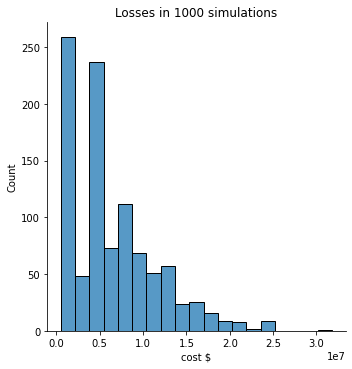

In [53]:
sns.displot(data=loss_per_yr(p, jets, props, 1000), kind='hist')
c=plt.title("Losses in 1000 simulations")
x=plt.xlabel("cost $")

**Distribution of the 3yr mean**

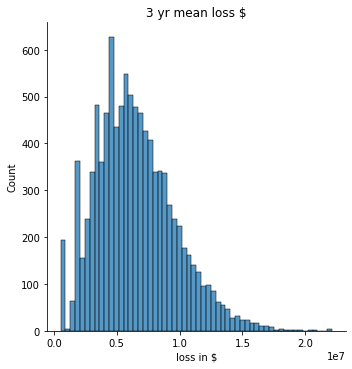

In [43]:
sns.displot(data=means_3yr, kind='hist')
z=plt.title('3 yr mean loss $')
v=plt.xlabel('loss in $')

## Low Commission Plan

In [12]:
## Loss Conversion Plan Fuction

def lcp(trials, loss_prob):
  """
  Compute cost of Loss Coversion Plan over 3 year period
  Repeat 'trials' times
  Return mean cost
  """
  # premium max and min
  rate_hi = 1.05 / 100
  rate_lo = 0.5 / 100

  up_bound = rate_hi * insured
  lo_bound = rate_lo * insured

  runs = np.array([])

  for simulation in range(trials):
    prem3yr = np.array([])
    loss3yr = loss_per_yr(loss_prob, jets, props, 3)

    # calculate annual premium in 3yr period
    count = 1
    for i in loss3yr:
      if up_bound < max(i*1.35, lo_bound):
        prem = up_bound
      else:
        prem = max(i*1.35, lo_bound)
      prem3yr = np.append(prem3yr, prem)
      count+=1

    tot_prem = sum(prem3yr)
    credit = max((tot_prem - sum(loss3yr))*0.1, 0)
    
    plan_cost = tot_prem - credit
    runs = np.append(runs, plan_cost)

  return (np.mean(runs), runs)



In [14]:
# 10 simulations
lcp(10, p)

(22663902.360725157,
 array([24481600.        , 29120328.39793801, 25716179.41273639,
        28471016.32933583, 22128703.01011853, 22569520.46127924,
        19109631.25594347, 16255999.10072123, 18903844.06822585,
        19882201.570953  ]))

## Profit Commission Plan

In [15]:
## Function to simulate cost of Profit Commission Plan

def pcp(trials, loss_prob):
  """
  Compute cost of plan 'trials' times and return the mean
  """
  prem_plus = (0.25 / 100) * insured
  up_bound = 0.01 * insured

  runs = np.array([])

  for j in range(trials):
    premiums = np.array([])
    credits = np.array([])
    # simulate annual losses over 3yr period
    loss3yr = loss_per_yr(loss_prob, jets, props, 3)

    # calculate annual premium and credit over 3yr period 
    for i in loss3yr:
      if up_bound < i + prem_plus:
        prem = up_bound
      else:
        prem = i + prem_plus
      premiums = np.append(premiums, prem)
      
      # annual credit
      cred = max(prem - (i + ((0.2 / 100) * insured)), 0)
      credits = np.append(credits, cred)

    # totals at end of 3yr period
    total_prem = sum(premiums)
    total_cred = sum(credits)

   
    # plan cost
    plan_cost = total_prem - max(total_cred, 0)
    runs = np.append(runs, plan_cost)
    
  return (np.mean(runs), runs)



## Simulate plans to get average cost

In [18]:
print("Expected Value of Loss Commission Plan cost after 1000 simulations:", np.round(lcp(10000, p)[0], 2))

Expected Value of Loss Commission Plan cost after 1000 simulations: 21583889.6


In [16]:
print("Expected Value of Profit Commission Plan cost after 1000 simulations:", np.round(pcp(10000, p)[0], 2))

Expected Value of Profit Commission Plan cost after 1000 simulations: 20044533.83


### Visualizations

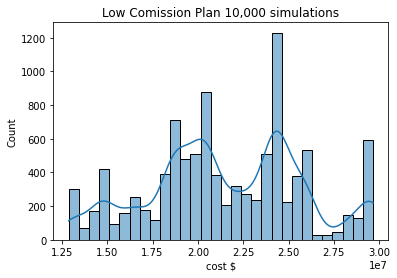

In [36]:
sns.histplot(data=lcp(10000,p)[1], bins=30, kde=True)
c=plt.title("Low Comission Plan 10,000 simulations")
x=plt.xlabel("cost $")

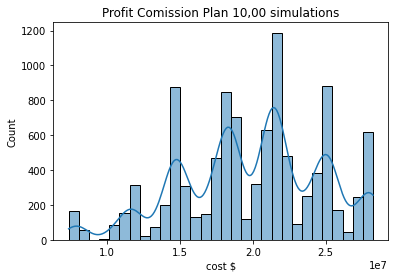

In [37]:
sns.histplot(data=pcp(10000,p)[1], bins=30, kde=True)
c=plt.title("Profit Comission Plan 10,00 simulations")
x=plt.xlabel("cost $")

#### **Joint visualizations**

In [23]:
# generate dataframe with simulation data for plotting
sims = 10000
lcp_sim = lcp(sims,p)[1]
pcp_sim = pcp(sims,p)[1]
data = {'lcp': lcp_sim, 'pcp': pcp_sim}
sims_df = pd.DataFrame(data)
# sims_df

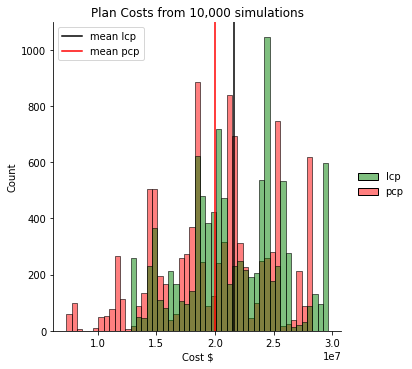

In [ ]:
## Plotting
sns.displot(data=sims_df, kind='hist', palette=['green', 'red'], fill=True)
plt.xlabel('Cost $')
plt.axvline(x=sims_df['lcp'].mean(), color='k', label='mean lcp')
plt.axvline(x=sims_df['pcp'].mean(), color='r', label='mean pcp')
plt.legend()
t=plt.title("Plan Costs from 10,000 simulations")

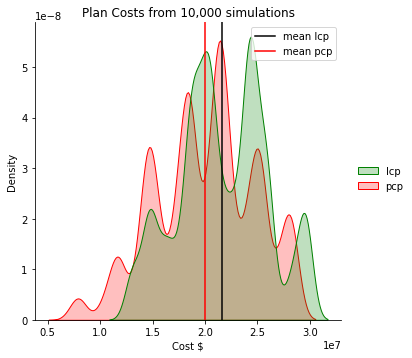

In [40]:
## Plotting - kernel density 
sns.displot(data=sims_df, kind='kde', palette=['green', 'red'], fill=True)
plt.xlabel('Cost $')
plt.axvline(x=sims_df['lcp'].mean(), color='k', label='mean lcp')
plt.axvline(x=sims_df['pcp'].mean(), color='r', label='mean pcp')
plt.legend()
t=plt.title("Plan Costs from 10,000 simulations")

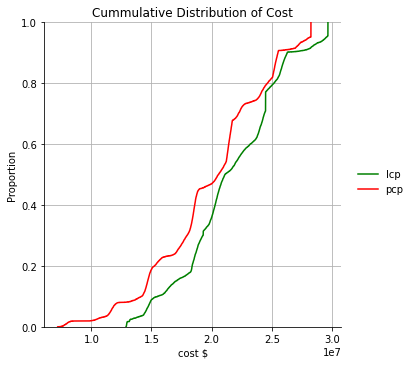

In [29]:
sns.displot(sims_df, palette=['green', 'red'], kind="ecdf")
plt.xlabel('cost $')
plt.grid(b=True, which='major', axis='both')
z=plt.title('Cummulative Distribution of Cost')

## Cost variation as a function of crash probability

What if the probability of crashing changed?

In [25]:
# array of crash probabilities
risk = np.linspace(0.0004, 0.035, 40)
risk

array([0.0004    , 0.00128718, 0.00217436, 0.00306154, 0.00394872,
       0.0048359 , 0.00572308, 0.00661026, 0.00749744, 0.00838462,
       0.00927179, 0.01015897, 0.01104615, 0.01193333, 0.01282051,
       0.01370769, 0.01459487, 0.01548205, 0.01636923, 0.01725641,
       0.01814359, 0.01903077, 0.01991795, 0.02080513, 0.02169231,
       0.02257949, 0.02346667, 0.02435385, 0.02524103, 0.02612821,
       0.02701538, 0.02790256, 0.02878974, 0.02967692, 0.0305641 ,
       0.03145128, 0.03233846, 0.03322564, 0.03411282, 0.035     ])

Loss in dollars as function of probability

In [26]:
# Average 3 yr loss as a function of crash probability
iters = 1000

scenarios = np.array([])
for prob in risk:
  ev = np.array([])

  # simulate a number of times for current probability
  for y in range(iters):
    ev = np.append(ev, np.mean(loss_per_yr(prob, jets, props, 3)))
    # alternate; not taking 3 year average
    # ev = np.append(ev, loss_per_yr(prob, jets, props, 1))

  scenarios = np.append(scenarios, np.mean(ev))


Plan costs as a function of crash probability

In [27]:
# Low Commission Plan
iters = 1000

lc_plans = np.array([])
pc_plans = np.array([])

for j in risk:

  # simulate plans many times for current probability
  lc_plans = np.append(lc_plans, lcp(iters,j)[0])
  pc_plans = np.append(pc_plans, pcp(iters,j)[0])
 


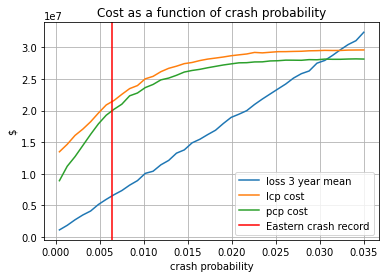

In [32]:
fig, ax = plt.subplots()
# ax.plot(risk, scenarios1, label='without 3 year mean')
ax.plot(risk, scenarios, label='loss 3 year mean')
ax.plot(risk, lc_plans, label='lcp cost')
ax.plot(risk, pc_plans, label='pcp cost')
ax.set_title('Cost as a function of crash probability')
ax.set_ylabel('$')
ax.set_xlabel('crash probability')
plt.axvline(x=p, color='r', label='Eastern crash record')
ax.grid(b=True, which='major', axis='both')
o=ax.legend()

After a certain probability, the plan premiums reach their upper bound.